In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import random
import cv2
import os
import shutil
import glob as gb
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Image
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, f1_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.metrics import Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
## Load Data
image_dir = Path('Dataset')

# Mendapatkan path file dan label
filepaths = list(image_dir.glob(r'**/*.*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

file_extensions = set(path.suffix.lower() for path in filepaths)
print("Ekstensi File yang Ditemukan:", file_extensions)

filepaths = pd.Series(filepaths, name='Filepaths').astype(str)
labels = pd.Series(labels, name='Labels')

# Menggabungkan path file dengan label
images_df = pd.concat([filepaths, labels], axis=1)

# Acak data dan reset index
images_df = images_df.sample(frac=1).reset_index(drop=True)

# Menampilkan data
images_df.head()

Ekstensi File yang Ditemukan: {'.png', '.jpg'}


,Filepaths,Labels
0,Dataset\matang\healthy (961).jpg,matang
1,Dataset\matang\healthy (921).jpg,matang
2,Dataset\belum matang\u (876).jpg,belum matang
3,Dataset\matang\r (2204).jpg,matang
4,Dataset\belum matang\u (870).jpg,belum matang


In [3]:
images_df.Labels.value_counts()

Labels
belum matang    60
matang          50
Name: count, dtype: int64

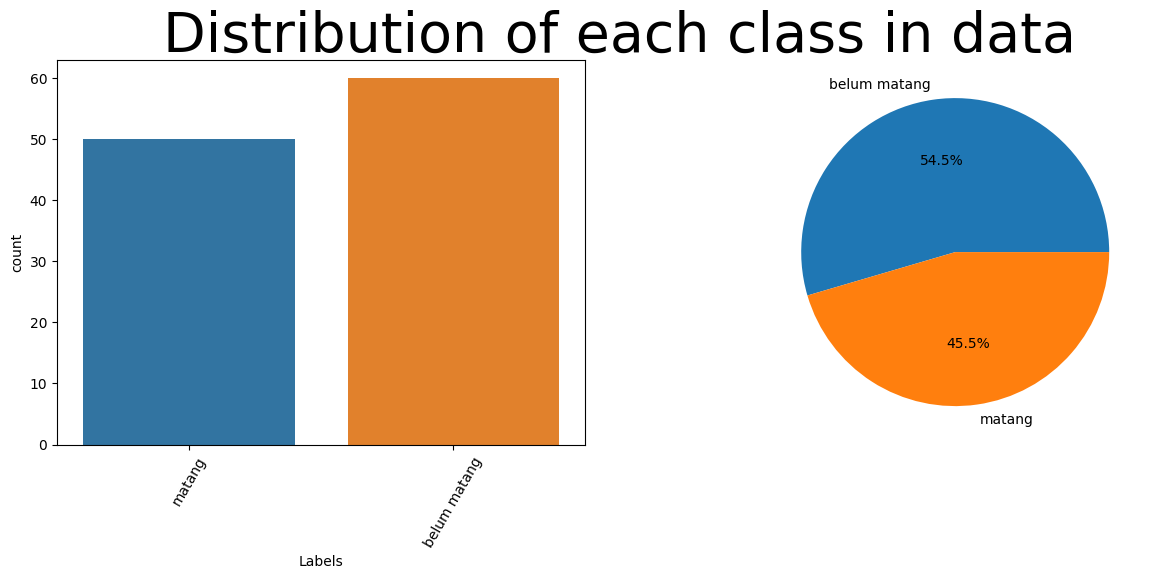

In [4]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=images_df,x='Labels')
plt.xticks(rotation = 60)
plt.subplot(1,2,2)
plt.pie(x = images_df['Labels'].value_counts().values, labels=images_df['Labels'].value_counts().index,autopct='%1.1f%%')
plt.suptitle('Distribution of each class in data',size=40)
plt.show()

In [5]:
train_df, test_df = train_test_split(images_df, test_size=0.4, random_state=2, shuffle=True, stratify=images_df['Labels'])
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=2, shuffle=True, stratify=test_df['Labels'])

In [6]:
# Tetapkan seed acak
seed_value = 2
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)
tf.config.experimental.enable_op_determinism()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator untuk data pelatihan tanpa augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    rotation_range=30,  # Rentang rotasi
    zoom_range=0.15,  # Rentang zoom
    width_shift_range=0.2,  # Rentang perpindahan vertikal
    height_shift_range=0.2,  # Rentang perpindahan horizontal
    shear_range=0.15,  # Rentang shear
    horizontal_flip=True,  # Membalik secara horizontal
    vertical_flip=True,  # Membalik secara vertikal
    fill_mode="nearest"  # Metode pengisian piksel yang hilang
)

# ImageDataGenerator untuk data validasi tanpa augmentasi
val_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    rotation_range=30,  # Rentang rotasi
    zoom_range=0.15,  # Rentang zoom
    width_shift_range=0.2,  # Rentang perpindahan vertikal
    height_shift_range=0.2,  # Rentang perpindahan horizontal
    shear_range=0.15,  # Rentang shear
    horizontal_flip=True,  # Membalik secara horizontal
    vertical_flip=True,  # Membalik secara vertikal
    fill_mode="nearest"  # Metode pengisian piksel yang hilang
)

# ImageDataGenerator untuk data pengujian tanpa augmentasi
test_datagen = ImageDataGenerator(
    rescale=1./255  # Hanya normalisasi
)

# Flow from DataFrame untuk data pelatihan
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Filepaths",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=16,
    shuffle=True
)

# Flow from DataFrame untuk data validasi
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="Filepaths",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=16,
    shuffle=False
)

# Flow from DataFrame untuk data pengujian
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Filepaths",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=16,
    shuffle=False
)


Found 66 validated image filenames belonging to 2 classes.
Found 22 validated image filenames belonging to 2 classes.
Found 22 validated image filenames belonging to 2 classes.


In [8]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                                 
 dense (Dense)               (None, 64)                5

In [10]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
epoch = 10

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=epoch,
                    verbose=1,
                    callbacks=callback)

Epoch 1/10
5/5 [==============================] - 4s 542ms/step - loss: 1.7798 - accuracy: 0.4545 - val_loss: 0.3268 - val_accuracy: 0.9091
Epoch 2/10
5/5 [==============================] - 2s 424ms/step - loss: 0.3648 - accuracy: 0.7727 - val_loss: 1.2569 - val_accuracy: 0.5909
Epoch 3/10
5/5 [==============================] - 2s 443ms/step - loss: 0.4407 - accuracy: 0.8636 - val_loss: 0.1621 - val_accuracy: 0.8636
Epoch 4/10
5/5 [==============================] - 2s 430ms/step - loss: 0.1082 - accuracy: 0.9394 - val_loss: 0.0504 - val_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 2s 407ms/step - loss: 0.0582 - accuracy: 0.9848 - val_loss: 0.1047 - val_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 2s 406ms/step - loss: 0.0256 - accuracy: 1.0000 - val_loss: 0.0210 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 2s 523ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 8/10
5/5 [====

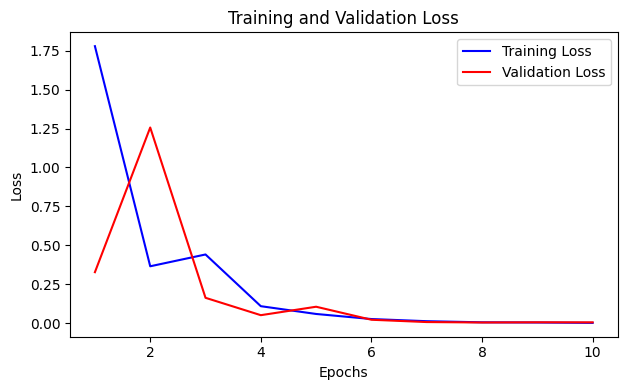

In [12]:
# Mengambil data dari history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()

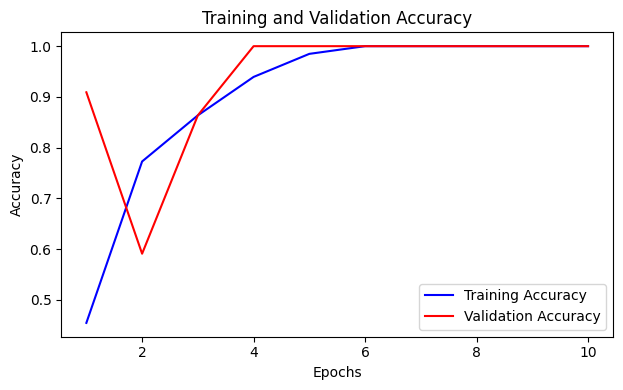

In [13]:
# Mengambil data dari history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)

labels = train_generator.class_indices
labels = dict((v,k) for k, v in labels.items())

print(labels)
print(pred)

2/2 [==============================] - 0s 37ms/step
{0: 'belum matang', 1: 'matang'}
[0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 0]


In [15]:
print(classification_report(test_generator.classes, pred, target_names=['belum matang', 'matang']))
print('--------------------------------')
print(confusion_matrix(test_generator.classes, pred))
print('--------------------------------')
# Extracting F1-score, recall, precision, and accuracy
f1_value = f1_score(test_generator.classes, pred, average='weighted')
recall = recall_score(test_generator.classes, pred, average='weighted')
precision = precision_score(test_generator.classes, pred, average='weighted')
accuracy = accuracy_score(test_generator.classes, pred)


# Print with four decimal places
print(f'F1 Score: {round(f1_value, 4)}')
print(f'Recall: {round(recall, 4)}')
print(f'Precision: {round(precision, 4)}')
print(f'Accuracy: {round(accuracy, 4)}')

              precision    recall  f1-score   support

belum matang       1.00      1.00      1.00        12
      matang       1.00      1.00      1.00        10

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

--------------------------------
[[12  0]
 [ 0 10]]
--------------------------------
F1 Score: 1.0
Recall: 1.0
Precision: 1.0
Accuracy: 1.0


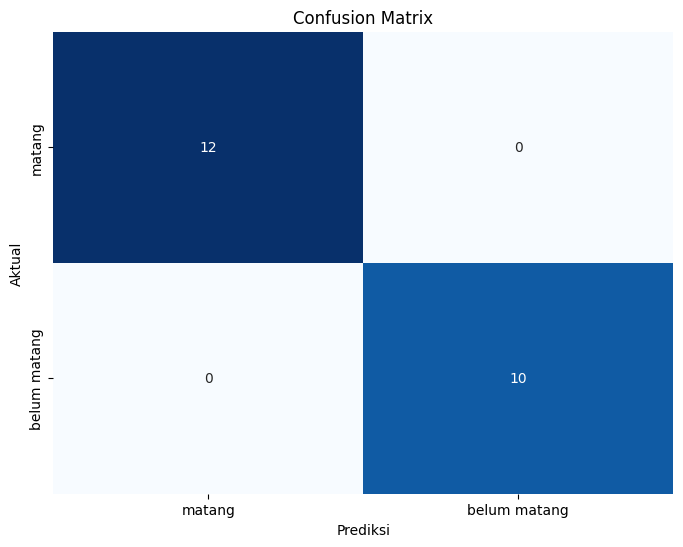

In [16]:
cm = confusion_matrix(test_generator.classes, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['matang', 'belum matang'],
            yticklabels=['matang', 'belum matang'])
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [17]:
#simpan model
file_name = 'model.h5'
model.save(file_name)  
print(f'model{file_name} telah tersimpan')

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


modelmodel.h5 telah tersimpan
